In [1]:
import spacy
import re
import pickle
import ast
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, hamming_loss, jaccard_score
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
from datasets import Dataset
from datasets import load_metric
import matplotlib.pyplot as plt
from PIL import Image

c:\Users\tomse\OneDrive - IMT Mines Albi\Documents\école\IFIE2\Stage2\stage\intern\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from models import description,trad,functions
from vect import simi

Files already downloaded and verified


In [ ]:
df=trad.final('excel.xlsx')


In [3]:
df=pd.read_excel('ready2.xlsx')

In [4]:


desc = []

try:
    with open('desc_progress2.pkl', 'rb') as f:
        desc = pickle.load(f)
except FileNotFoundError:
    pass
i = len(desc)
for x in df['Bildbez'][len(desc):]:  
    path = f'../Images/{x}.jpg'
    try:
        res = description.results(path)
        c = description.compare_lists(res[1], res[2], res[3])
        f = description.score(c[0], c[1], c[2], res[0])
        if f[1] > 50:
            detail = description.details(path, res)
            a = [f[0]] + detail
            desc.append(a)
        else:
            desc.append([''])

    except FileNotFoundError:
        desc.append([''])


    with open('desc_progress2.pkl', 'wb') as f:
        pickle.dump(desc, f)

    i += 1

    print(f'Progess : {100*i/df.shape[0]}%')

df['Description']=desc
df.to_excel('ready2.xlsx',index=False)

In [5]:
df1=pd.read_excel('excel.xlsx')
df['class']=df1['Hauptoberkategorie']

def convert_to_list(value):
    try:
        return ast.literal_eval(value)
    except (ValueError, SyntaxError):
        return value

df['Description']=df['Description'].apply(convert_to_list)  #When loading a excel file, all values will be strings so we need to convert them back to list

for col in df.columns:
    if col in ['Photo scene','Photo title','Note','Description']:   
        df[col]=df[col].fillna('')
    else:
        df[col]=df[col].fillna(0)


y_true=df.drop(columns=['Bildbez','Photo scene','Photo title','Note','class','Description'])


In [ ]:

x=x=[df['Photo scene'],df['Photo title'],df['Note']]
df=df.drop(columns=['Photo scene','Photo title','Note'])

a=[]
for i in x[0]:
    numbers = re.findall(r'-?\d+\.?\d*', i)
    a.append([int(num) if num.isdigit() else float(num) for num in numbers])


b=[]
for i in x[1]:
    if type(i)==str:
        numbers = re.findall(r'-?\d+\.?\d*', i)
        b.append([int(num) if num.isdigit() else float(num) for num in numbers])
    else:
        b.append(i)

c=[]
for i in x[2]:
    if type(i)==str:
        numbers = re.findall(r'-?\d+\.?\d*', i)
        c.append([int(num) if num.isdigit() else float(num) for num in numbers])
    else:
        c.append(i)

        
df['Photo motif']=a
df['Photo title']=b
df['Note']=c



In [ ]:
benchmark=functions.benchmark(df)
y_pred=functions.prediction_list(df[['Photo scene','Photo title','Note','Description']],benchmark)

In [ ]:
y_pred=pd.read_csv('y_pred.csv')

In [6]:
import random
import numpy as np
from sklearn.utils.class_weight import compute_class_weight


In [7]:
# Set random seeds for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)


# Set PyTorch to be deterministic
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Concatenate sentence columns into a single text field
df_text = df['Photo scene'] + ' ' + df['Photo title'] + ' ' + df['Note'].fillna('') + ' ' + df['Description'].apply(lambda x: ' '.join(x))

# Extract labels
label=df.drop(columns=['Bildbez','Photo scene','Photo title','Note','class','Description'])
label_columns = label.columns
df_labels = df[label_columns].values

# Split dataset into train and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(df_text, df_labels, test_size=0.2, random_state=42)
# Convert numpy arrays to torch tensors
train_labels_tensor = torch.tensor(train_labels, dtype=torch.float32)
val_labels_tensor = torch.tensor(val_labels, dtype=torch.float32)
all_labels_tensor = torch.tensor(df_labels, dtype=torch.float32)

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',cache_dir='c:/Stage/cache')

# Tokenize dataset
train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(val_texts.tolist(), truncation=True, padding=True, max_length=512)
all_text=tokenizer(df_text.tolist(), truncation=True, padding=True, max_length=512)

# Convert to Dataset format
train_dataset = Dataset.from_dict({
    'input_ids': train_encodings['input_ids'],
    'attention_mask': train_encodings['attention_mask'],
    'labels': train_labels_tensor
})
val_dataset = Dataset.from_dict({
    'input_ids': val_encodings['input_ids'],
    'attention_mask': val_encodings['attention_mask'],
    'labels': val_labels_tensor
})

all_dataset=Dataset.from_dict({
    'input_ids': all_text['input_ids'],
    'attention_mask': all_text['attention_mask'],
    'labels': all_labels_tensor
})

sub=['1_1','1_2','1_3','1_4','1_5','2_1','2_2','2_3','3_1','4_3','5_1','5_2','5_3','5_4','5_5','6_1','6_2','6_3','6_4','6_5','4_4','4_1','3_2']
sub_cat=dict(zip(label_columns,sub))


In [ ]:
preds=[]
probs=[]
benchs=[round(0.1*i,2) for i in range(1,10)]


for x in [0.25,0.3,0.35]:
    for learn_rate in [2e-4,2e-3]:


        # Define model
        model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_columns), problem_type="multi_label_classification")

        # Define training arguments
        training_args = TrainingArguments(
            output_dir='./results',
            evaluation_strategy='epoch',
            save_strategy='epoch',  
            learning_rate=learn_rate,
            per_device_train_batch_size=8,
            per_device_eval_batch_size=8,
            num_train_epochs=3,
            weight_decay=0.01,
            logging_dir='./logs',
            logging_steps=10,
            save_total_limit=1,
            load_best_model_at_end=True,
            metric_for_best_model="f1"
        )

        # Data collator
        data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


        def compute_metrics(eval_pred, threshold):
            predictions, labels = eval_pred.predictions, eval_pred.label_ids
            predictions = torch.sigmoid(torch.tensor(predictions))  # Apply sigmoid to get probabilities 
            pred_labels = (predictions > threshold).int().numpy()  # Convert probabilities to binary labels
            labels = labels.astype(int)  # Ensure labels are also in integer format
            f1 = f1_score(labels, pred_labels, average='macro', zero_division=1)
            
            return {"eval_f1": f1}



        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=val_dataset,
            data_collator=data_collator,
            tokenizer=tokenizer,
            compute_metrics=lambda p: compute_metrics(p, x)
        )

        # Train the model
        trainer.train()

        # Evaluate the model
        eval_results = trainer.evaluate()
        print(f"Evaluation Results: {eval_results}")

        # Make predictions
        predictions = trainer.predict(all_dataset)
        pred_probs = torch.sigmoid(torch.tensor(predictions.predictions))
        pred_labels = (pred_probs > x).int()
        probs.append(pred_probs)
        preds.append(pred_labels)



In [9]:
preds_df={}
probs_df={}
for i in range (1,len(preds)+1):
    preds_df[f'y_pred{i}']=pd.DataFrame(preds[i-1],columns=label_columns,index=df['Bildbez'])
    probs_df[f'y_prob{i}']=pd.DataFrame(probs[i-1],columns=label_columns,index=df['Bildbez'])
    


with open('bert_preds10.pkl', 'wb') as file:
    pickle.dump(preds_df, file)

with open('bert_probs10.pkl', 'wb') as file:
    pickle.dump(probs_df, file)


In [21]:
with open('bert_preds.pkl', 'rb') as file:
    preds_df = pickle.load(file)

with open('bert_probs.pkl', 'rb') as file:
    probs_df = pickle.load(file)

In [10]:
results=[]  # % of true labels in the predicted labels/ % of true labels predicted out of all the true labels
for x in preds_df:
    t=0
    result=[]
    for i in range(preds_df[x].shape[0]):
        pred_row=preds_df[x].iloc[i]
        true_row=y_true.iloc[i]
        pred_labels=[col for col in pred_row.index if pred_row[col]==1]
        true_labels=[col for col in true_row.index if true_row[col]==1]
        c=0
        for y in pred_labels:
            if y in true_labels:
                c+=1
        if len(pred_labels)!=0:
            result.append([c/len(pred_labels),c/len(true_labels)])
            if c/len(pred_labels)+c/len(true_labels)>1.2:
                t+=1
        else:
            result.append([0,0])
    print(t)        
    results.append(result)
        

0
32
0
52
0
0


In [18]:
df[df['Bildbez']=='TN2_F62']

,Bildbez,Functional Change,Appearance Change,Illness,Dying or Death,Aging as natural process,Mobility,Infrastructure,Aids in everyday life,Education and mental stimulation,...,Cultural experience and enjoyment,Pleasure and recreation,Experience of time,Control,Craft and technology,Photo scene,Photo title,Note,class,Description
14,TN2_F62,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,Tea in the café,Indulgence,,6,[a table with a glass of wine and a vase of fl...


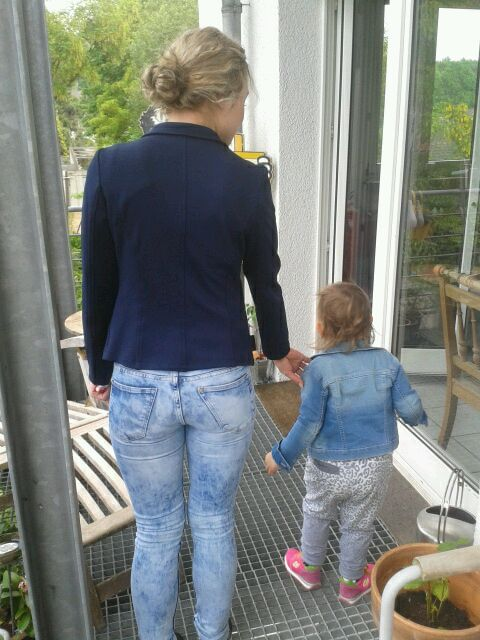

True labels :  ['Family and Friends']
Predicted labels :  ['Family and Friends']
1.0 1.0


In [12]:
results=[]  # % of true labels in the predicted labels/ % of true labels predicted out of all the true labels
x='y_pred2'
t=0
result=[]
for i in range(preds_df[x].shape[0]):
    pred_row=preds_df[x].iloc[i]
    true_row=y_true.iloc[i]
    pred_labels=[col for col in pred_row.index if pred_row[col]==1]
    true_labels=[col for col in true_row.index if true_row[col]==1]
    c=0
    for y in pred_labels:
        if y in true_labels:
            c+=1
    if len(pred_labels)!=0:
        if c/len(pred_labels)+c/len(true_labels)>=2:
            a=df['Bildbez'][i]
            display(Image.open(f'../Images/{a}.jpg'))
            print('True labels : ',true_labels)
            print('Predicted labels : ',pred_labels)
            print(c/len(true_labels),c/len(pred_labels))
                


In [9]:
bench=[0.5+i/10 for i in range(16)]

for name in range (1,11):
    goods=[]
    if name==1:
        name=''
    with open(f'bert_preds{name}.pkl', 'rb') as file:
        preds_df = pickle.load(file)
    for j in range (len(bench)):
        good=[]
        for x in preds_df:
            t=0
            for i in range(preds_df[x].shape[0]):
                pred_row=preds_df[x].iloc[i]
                true_row=y_true.iloc[i]
                pred_labels=[col for col in pred_row.index if pred_row[col]==1]
                true_labels=[col for col in true_row.index if true_row[col]==1]
                c=0
                for y in pred_labels:
                    if y in true_labels:
                        c+=1
                if len(pred_labels)!=0:
                    test=c/len(pred_labels)+c/len(true_labels)
                    if j!=len(bench)-1:
                        if test>=bench[j] and test<bench[j+1]:
                            t+=1
                    else:
                        if test>=bench[j]:
                            t+=1
            good.append(t)
        goods.append(good)
    goods=pd.DataFrame(goods,index=bench)
    print(goods)
    print('----------------------------')

       0   1    2    3    4   5   6   7  8
0.5    2   1    0    0    0   0   0   0  0
0.6   10   2    2    1    0   0   0   0  0
0.7   19   7    0    0    0   0   0   0  0
0.8    3  10    4    3    1   1   0   0  0
0.9    3   1    0    0    0   0   0   0  0
1.0    6  21   13    9    1   8   0   0  0
1.1   61   6    2    0    0   0   0   0  0
1.2  118   2    0    0    0   0   0   1  0
1.3   37  11   11    7    9   9  18  18  0
1.4   14   1    0    0    0   0   0   0  0
1.5    9  67   53   53   56  62  44  23  0
1.6    1  28   22   21   19  15   9   2  0
1.7    0   4    4    3    1   0   0   0  0
1.8    0   0    0    0    0   0   0   0  0
1.9    0   0    0    0    0   0   0   0  0
2.0    4  77  104  103  101  71  42  22  0
----------------------------
       0   1  2  3  4  5  6  7  8
0.5    0   2  0  0  0  0  0  0  0
0.6    0  56  0  0  0  0  0  0  0
0.7    0   0  0  0  0  0  0  0  0
0.8    0  11  0  0  0  0  0  0  0
0.9    0   3  0  0  0  0  0  0  0
1.0  305  15  0  0  0  0  0  0  0
1.

In [113]:
def pred(picture : str, model : int, sub_cat : dict):
    row=probs_df[f'y_prob{model}'].loc[picture].copy()
    main_cat=[]
    sub_cats=[]
    while True:
        max_prob=row.max()
        label=row.idxmax()
        sub=sub_cat[label]
        if sub[0] not in main_cat and max_prob>=model/10:
            main_cat.append(sub[0])
            sub_cats.append(label)
            row[label]=0
        elif sub[0] in main_cat:
            row[label]=0
        elif max_prob<model/10:
            break
    main=main_cat[0]
    print(f'The main categorie is {main}')
    print('The sub-catefogories are :')
    for x in sub_cats:
        print(x,sub_cat[x])


In [114]:
pred('TN1_F96',4,sub_cat)

The main categorie is 1
The sub-catefogories are :
Illness 1_3
Control 4_1


In [ ]:
pred_row=preds_df['y_pred1'].iloc[231]
true_row=y_true.iloc[231]
pred_labels=[true_row.index[col] for col in pred_row.index if pred_row[col]==1]
true_labels=[col for col in true_row.index if true_row[col]==1]
print(f'The true labels are : {true_labels}')
print()
print()
print(f'The predicted labels are : {pred_labels}')

In [ ]:
t=0
result=[]
for i in range(y_pred.shape[0]):
    pred_row=preds_df['y_pred2'].iloc[i]
    true_row=y_true.iloc[i]
    pred_labels=[true_row.index[col] for col in pred_row.index if pred_row[col]==1]
    true_labels=[col for col in true_row.index if true_row[col]==1]
    c=0
    lab=[]
    for y in pred_labels:
        if y in true_labels:
            lab.append(y)
            c+=1
    if len(pred_labels)!=0:
        result.append([c/len(pred_labels),c/len(true_labels)])
        if c/len(pred_labels)+c/len(true_labels)>1.2:
            t+=1
            print(c/len(pred_labels),c/len(true_labels))

    else:
        result.append([0,0])
print(t)        
results.append(result)

In [ ]:
probs=[]
for i in range (y_true.shape[0]):
    prob=[]
    true_row=y_true.iloc[i]
    prob_row=pred_probs[i]
    for j,col in enumerate(y_true.columns):
        if true_row[col]==1:
            prob.append(float(prob_row[j]))
        else:
            prob.append(0)
    probs.append(prob)

print(pd.DataFrame(probs))

In [ ]:
t=0
result=[]
for i in range(y_pred.shape[0]):
    pred_row=y_pred.iloc[i]
    true_row=y_true.iloc[i]
    pred_labels=[col for col in pred_row.index if pred_row[col]==1]
    true_labels=[col for col in true_row.index if true_row[col]==1]
    c=0
    for y in pred_labels:
        if y in true_labels:
            c+=1
    if len(pred_labels)!=0:
        result.append([c/len(pred_labels),c/len(true_labels)])
        if c/len(pred_labels)+c/len(true_labels)>1.2:
            t+=1
            print(c/len(pred_labels),c/len(true_labels))
    else:
        result.append([0,0])
print(t)        
results.append(result)

In [ ]:
for i in range (len(results)):
    to_plot=pd.DataFrame(results[i])
    plt.figure(figsize=(8, 6))
    to_plot.boxplot(column=[0,1])
    plt.title('Boxplots of Value1 and Value2')
    plt.ylabel('Values')
    plt.show()

In [ ]:


accuracy =  []
precision = [] 
recall= [] 
f1 = []  
roc_auc = []
hamming = []
jaccard = []



for i in range(len(y_test_true.columns)):
    y_pred1=y_test_pred[str(i)]
    y_true1=y_tes[i]

    accuracy.append(accuracy_score(y_true1, y_pred1))
    precision.append(precision_score(y_true1, y_pred1, average='micro')  )
    recall.append(recall_score(y_true1, y_pred1, average='micro')  )
    f1.append(f1_score(y_true1, y_pred1, average='micro')  )
    try:
        roc_auc.append(roc_auc_score(y_true1, y_pred1, average='micro')  )
    except ValueError:
        roc_auc.append(0.5)
    hamming.append(hamming_loss(y_true1, y_pred1))
    jaccard.append(jaccard_score(y_true1, y_pred1, average='micro'))





data = [accuracy, precision, recall, f1, roc_auc, hamming, jaccard]
labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC', 'Hamming Loss', 'Jaccard Score']
plt.figure(figsize=(10, 6))
plt.boxplot(data, labels=labels)
plt.title(f'Boxplot')
plt.ylabel('Score')
plt.xlabel('Metric')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [ ]:

accuracy =  []
precision = [] 
recall= [] 
f1 = []  
roc_auc = []
hamming = []
jaccard = []



for x in y_true.columns:
    y_true1=y_true[x]
    y_pred1=y_pred[x]

    accuracy.append(accuracy_score(y_true1, y_pred1))
    precision.append(precision_score(y_true1, y_pred1, average='micro')  )
    recall.append(recall_score(y_true1, y_pred1, average='micro')  )
    f1.append(f1_score(y_true1, y_pred1, average='micro')  )
    roc_auc.append(roc_auc_score(y_true1, y_pred1, average='micro')  )
    hamming.append(hamming_loss(y_true1, y_pred1))
    jaccard.append(jaccard_score(y_true1, y_pred1, average='micro'))
    


In [ ]:
import matplotlib.pyplot as plt


data = [accuracy, precision, recall, f1, roc_auc, hamming, jaccard]
labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC', 'Hamming Loss', 'Jaccard Score']
plt.figure(figsize=(10, 6))
plt.boxplot(data, labels=labels)
plt.title(f'Boxplot')
plt.ylabel('Score')
plt.xlabel('Metric')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [ ]:
import pickle

desc = []
i = 0
try:
    with open('desc_progress.pkl', 'rb') as f:
        desc = pickle.load(f)
except FileNotFoundError:
    pass

for x in df['Bildbez'][len(desc):]:  
    print(i)
    path = f'../Images/{x}.jpg'
    try:
        res = description.results(path)
        c = description.compare_lists(res[1], res[2], res[3])
        f = description.score(c[0], c[1], c[2], res[0])
        if f[1] > 0.5:
            detail = description.details(path, res)
            a = [f[0]]
            for y in detail:
                a.append(y)
            desc.append(a)
        else:
            desc.append([''])

    except FileNotFoundError:
        desc.append([''])


    with open('desc_progress.pkl', 'wb') as f:
        pickle.dump(desc, f)

    i += 1


In [ ]:
nlp = spacy.load("en_core_web_md")
desc_vec=[]
for y in desc:
    if type(y)==list:
        a=[]
        for x in y:
            a.append(nlp(x).vector)
        desc_vec.append(a)
    else:
        desc_vec.append(nlp(y).vector)

df['description']=desc_vec